# MAT330 - Practical work on Machine Learning

## Example : hurricane meteorological data

Sophie Giffard-Roisin (sophie.giffard@univ-grenoble-alpes.fr)
Julien Brajard (julien.brajard@nersc.no)

## Introduction
This is an initiation to introduce regression using machine learning and get you to know how it works.

We will use a real hurricane meteorological dataset, which typical goal is to estimate the current stength of the hurricane or to predict its evolution. 
<img src="https://github.com/sophiegif/ramp_kit_storm_forecast_new/blob/master/figures_pynb/all_storms_since1979_IBTrRACKS_newcats.png?raw=true" width="70%">
<div style="text-align: center">Database: tropical/extra-tropical storm tracks since 1979. Dots = initial position, color = maximal storm strength according to the Saffir-Simpson scale.</div>


### Requirements

* numpy  
* matplotlib
* pandas 
* scikit-learn   

In [ ]:
%matplotlib inline
import os
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pandas as pd

## The data

In [83]:
train_filename = 'https://raw.githubusercontent.com/brajard/MAT330-Practical-work/master/data/train.csv'
data_train = pd.read_csv(train_filename)

target = pd.Series (np.nan, data_train.index)
look_ahead = 4 #6h time step = 24h
for i in range(len(target)-look_ahead):
    if data_train.stormid[i] == data_train.stormid[i+look_ahead]:
        target[i] = data_train.windspeed[i+4]
data_train = data_train.assign(target = target)
data_train.dropna(inplace=True)

In [ ]:
# Extract the predictor (but not the target -> data leakage)
X = data_train.drop('target',axis=1, inplace=False)
y = data_train['target']


In [84]:
# Do the same with the test dataset
test_filename = 'https://raw.githubusercontent.com/brajard/MAT330-Practical-work/master/data/test.csv'
data_test = pd.read_csv(test_filename)

target = pd.Series (np.nan, data_test.index)
look_ahead = 4 #6h time step = 24h
for i in range(len(target)-look_ahead):
    if data_test.stormid[i] == data_test.stormid[i+look_ahead]:
        target[i] = data_test.windspeed[i+4]
data_test = data_test.assign(target = target)
data_test.dropna(inplace=True)

Xtest = data_test.drop('target',axis=1,inplace=False)
ytest = data_test['target']

### 1. 0D features from track data

A set of simple features has been extracted for each storm at each time point: 

- latitude, longitude: in degrees
- windspeed: current (max) windspeed (knots) 
- hemisphere:  South=0, North=1
- Jday predictor:  Gaussian function of (Julian day of storm init - peak day of the hurricane season), see (1)
- initial_max_wind: initial (max) windspeed of the storm 
- max_wind_change_12h: last 12h (max) windspeed change
- basin = based on the present location: 
       0 = NA - North Atlantic / 1 = SA - South Atlantic    / 2 = WP - West Pacific       / 3 = EP - East Pacific /
       4 = SP - South Pacific  / 5 = NI - North Indian      / 6 = SI - South Indian       / 7 = AS - Arabian Sea /
       8 = BB - Bay of Bengal  / 9 = EA - Eastern Australia / 10 = WA - Western Australia / 11 = CP - Central Pacific
       12 = CS - Carribbean Sea/ 13 = GM - Gulf of Mexico   / 14 = MM - Missing
- nature = nature of the storm  
       0 = TS - Tropical / 1 = SS - Subtropical / 2 = ET - Extratropical / 3 = DS - Disturbance /
       4 = MX - Mix of conflicting reports / 5 = NR - Not Reported / 6 = MM - Missing / 7 =  - Missing
- dist2land = current distance to the land (km)


(1) DeMaria, Mark, et al. "Further improvements to the statistical hurricane intensity prediction scheme (SHIPS)." Weather and Forecasting 20.4 (2005): 531-543. https://journals.ametsoc.org/doi/full/10.1175/WAF862.1


### 2. The reanalysis data

At each time step, we extracted 7 grids (11x11 pixels) of meteorological parameters centered on the current storm location. Their choice is based on the forecast literature, on personal experience and on known hypothesis of storm strengthening.

#### a) 25x25 degree z, u and v at 700hPa-level
First, we provide 3 maps of 25 x 25 degrees (lat/long) at 700hPa-level pressure: the altitude `z`, the u-wind `u` (positive if wind from the West) and the v-wind `v` (positive if wind from the South). These grids are subsampled to 11x11 pixels (1 pixel ~=2 degrees).


In [ ]:
data_train_z = X[[col for col in X.columns if col.startswith('z_')]]
data_train_z.head()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
sample_id=20 # sample number plotted - you can change it to see other storms and other instants
grid_l=11 # size of all 2D-grids (in pixels)

In [ ]:
params_25x25=['z','u','v']
plt.figure(figsize=(10,4))
for p,param in enumerate(params_25x25):
    image=np.zeros([grid_l,grid_l])
    for i in range(grid_l):
         for j in range(grid_l):
            image[i,j]=X[param+'_'+str(i)+'_'+str(j)][sample_id]
    plt.subplot(1,3,p+1)
    plt.imshow(np.array(image),extent=[-12,12,-12,12],
               interpolation='nearest', origin='lower', cmap='seismic')
    plt.xlabel('param '+param)
t=plt.suptitle('Example of 700-hPa level maps 25x25 degrees, centered in the storm location.'
         +'\n (altitude, u-wind and v-wind)')

Load also the test data:

## Linear model

### 1. Feature selection

In [75]:
from sklearn.preprocessing import StandardScaler

#Features to use
features = ['latitude', 'longitude', 'windspeed',
       'hemisphere', 'Jday_predictor', 'initial_max_wind',
       'max_wind_change_12h','dist2land']
Xin = X.get(features)
Xin_test = Xtest.get(features)

# one hot encoding


#Image processing....

# Equalization of the types:
Xin = Xin.astype(float)
Xin_test = Xin_test.astype(float)




### 2. Train into Val/Train

In [76]:
# The hard way (why?)
from sklearn.utils import shuffle
np.random.seed(10)
ids = shuffle(X.stormid.unique())

#Take 80% for training
limit_train = int(.8*len(ids))

#Index of training/val
idx_train = X.index[X.stormid.isin(ids[:limit_train])]
idx_val = X.index[X.stormid.isin(ids[limit_train:])]

X_train, y_train = Xin.loc[idx_train], y.loc[idx_train]
X_val, y_val = Xin.loc[idx_val], y.loc[idx_val]



### 3. Standardization
For all features, transform your data such that mean=0 and std=1 (on the training data), and use the same parameters for transforming the test data also. 

In [78]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(Xin_test)

### 4. Training

In [79]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train_scaled,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### 5. Validate the model

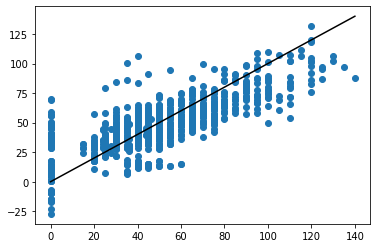

In [80]:
y_val_predict = linreg.predict(X_val_scaled)
plt.scatter(y_val,y_val_predict)
plt.plot([0,140],[0,140],'-k')
plt.show()

In [81]:
score = linreg.score(X_val_scaled,y_val)
print('linear regression score: {:.3f}'.format(score))

linear regression score: 0.605


### 3. Predicting the test dataset

In [82]:
y_test_predict = linreg.predict(X_test_scaled)
np.save('test_predict.npy',y_test_predict)